In [11]:
# Cell 1 – Imports, data load, figure directory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

# ---- data ----
DATA = Path("../data/processed/nasdaq_features.parquet")
df = pd.read_parquet(DATA)
display(df.head())

# ---- figure output folder ----
FIG_DIR = Path("../reports/plots")
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("Figures will be saved to:", FIG_DIR.resolve())



,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,TEDSpread,EFFR,...,GDP (in billion USD),Inflation Rate (%),Unemployment Rate (%),Economic Growth (%),log_ret,pct_change,sma_20,rsi_14,price_z,close_sma_ratio
2010-01-04,6.640000,6.810000,6.633333,6.746667,6514500.0,0.11,1.4419,20.04,0.17,0.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.143234,NaN
2010-01-05,6.643333,6.773333,6.643333,6.766667,4445100.0,0.11,1.4402,19.35,0.18,0.12,...,NaN,NaN,NaN,NaN,0.002960,0.002964,NaN,NaN,-1.142218,NaN
2010-01-06,6.733333,6.786667,6.720000,6.763333,7340100.0,0.11,1.4404,19.16,0.19,0.12,...,NaN,NaN,NaN,NaN,-0.000493,-0.000493,NaN,NaN,-1.142387,NaN
2010-01-07,6.750000,6.766667,6.630000,6.673333,8498400.0,0.11,1.4314,19.06,0.20,0.10,...,NaN,NaN,NaN,NaN,-0.013396,-0.013307,NaN,NaN,-1.146962,NaN
2010-01-08,6.676667,6.766667,6.626667,6.743333,4347600.0,0.11,1.4357,18.13,0.20,0.11,...,NaN,NaN,NaN,NaN,0.010435,0.010489,NaN,NaN,-1.143404,NaN


Figures will be saved to: /teamspace/studios/this_studio/TS/AI_TimeSeries_Forecasting/reports/plots


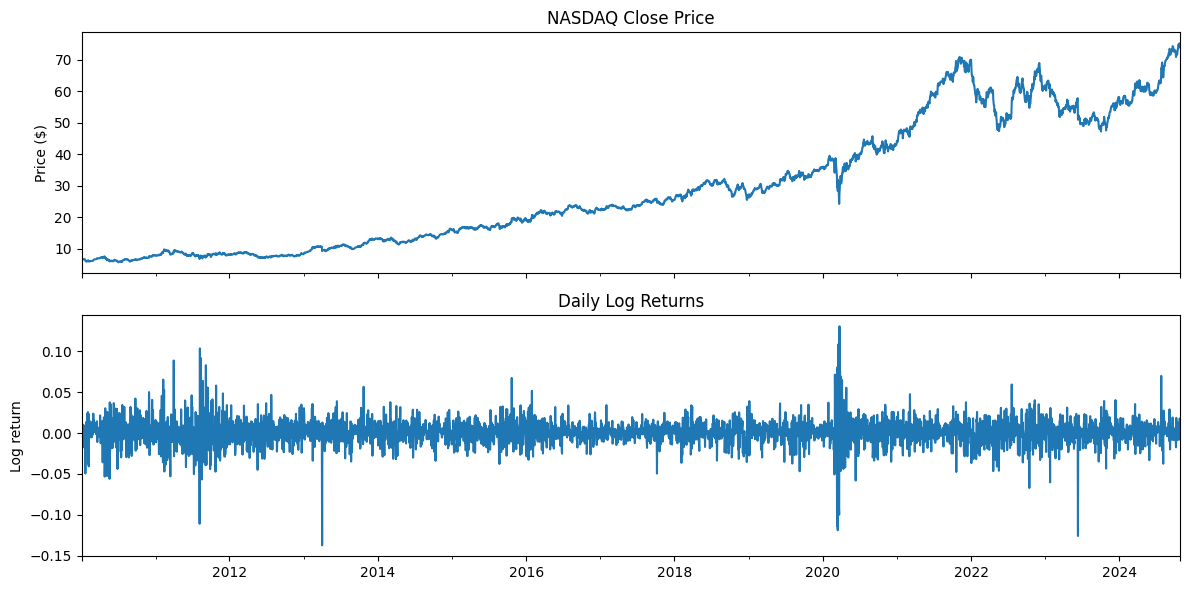

In [12]:
# Cell 2 – Price & log returns
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
df["Close"].plot(ax=ax[0], title="NASDAQ Close Price")
ax[0].set_ylabel("Price ($)")
df["log_ret"].plot(ax=ax[1], title="Daily Log Returns")
ax[1].set_ylabel("Log return")
plt.tight_layout()

fig.savefig(FIG_DIR / "price_and_log_returns.png", dpi=300, bbox_inches="tight")
plt.show()



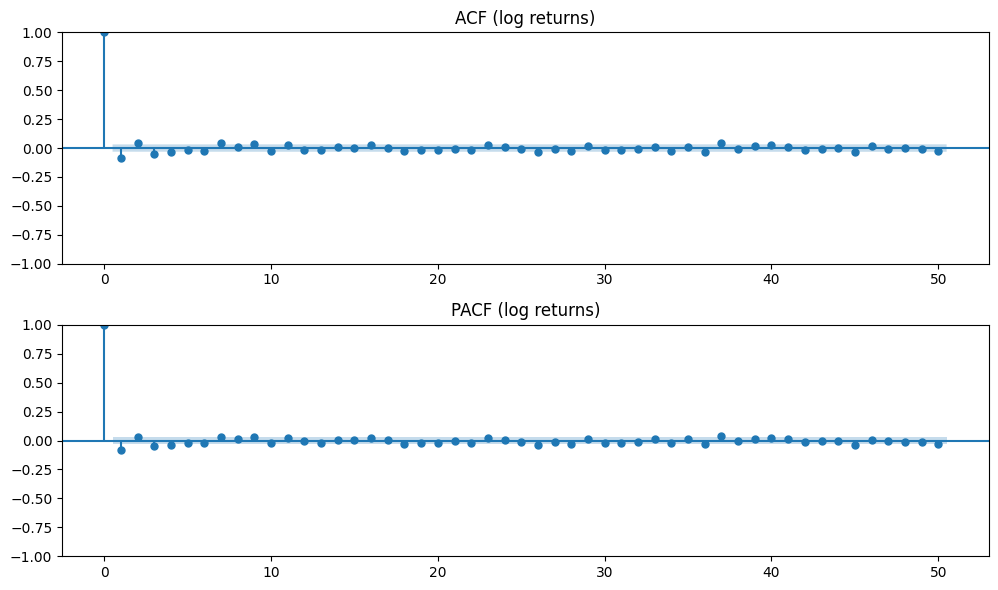

In [13]:
# Cell 3 – ACF & PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(df["log_ret"].dropna(), ax=ax[0], lags=50)
ax[0].set_title("ACF (log returns)")
plot_pacf(df["log_ret"].dropna(), ax=ax[1], lags=50, method="ywm")
ax[1].set_title("PACF (log returns)")
plt.tight_layout()

fig.savefig(FIG_DIR / "acf_pacf_log_returns.png", dpi=300, bbox_inches="tight")
plt.show()


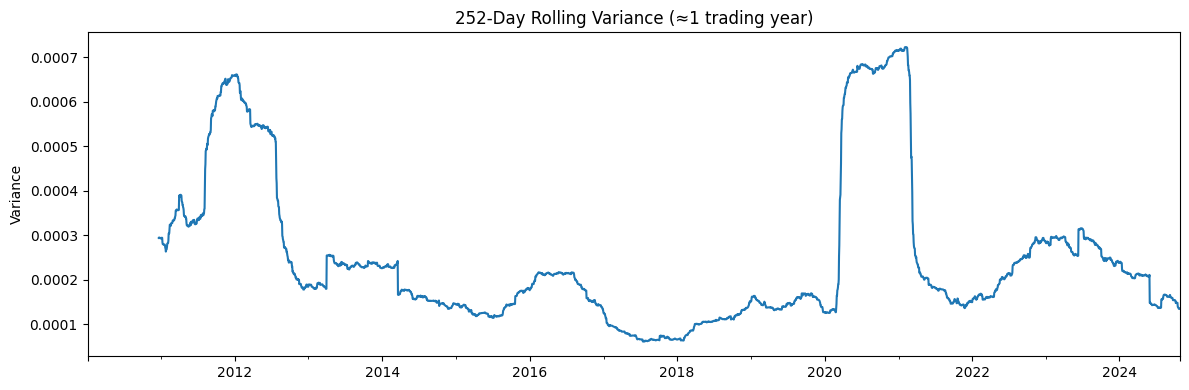

In [14]:
# Cell 4 – Rolling variance
rolling_var = df["log_ret"].rolling(window=252).var()
fig, ax = plt.subplots(figsize=(12, 4))
rolling_var.plot(ax=ax, title="252-Day Rolling Variance (≈1 trading year)")
ax.set_ylabel("Variance")
plt.tight_layout()

fig.savefig(FIG_DIR / "rolling_variance.png", dpi=300, bbox_inches="tight")
plt.show()


In [15]:
# Cell 5 – Stationarity tests
series = df["log_ret"].dropna()
adf_stat, adf_p, *_ = adfuller(series)
kpss_stat, kpss_p, *_ = kpss(series, regression="c", nlags="auto")

print(f"ADF statistic : {adf_stat: .4f} | p-value = {adf_p: .4g}")
print(f"KPSS statistic: {kpss_stat: .4f} | p-value = {kpss_p: .4g}\n")

if adf_p < 0.05 and kpss_p > 0.05:
    print("→ Likely stationary (reject unit-root, fail to reject stationarity).")
else:
    print("→ Non-stationary indication; consider differencing or transformation.")


ADF statistic : -24.4144 | p-value =  0
KPSS statistic:  0.0274 | p-value =  0.1

→ Likely stationary (reject unit-root, fail to reject stationarity).


/tmp/ipykernel_95679/316303001.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression="c", nlags="auto")


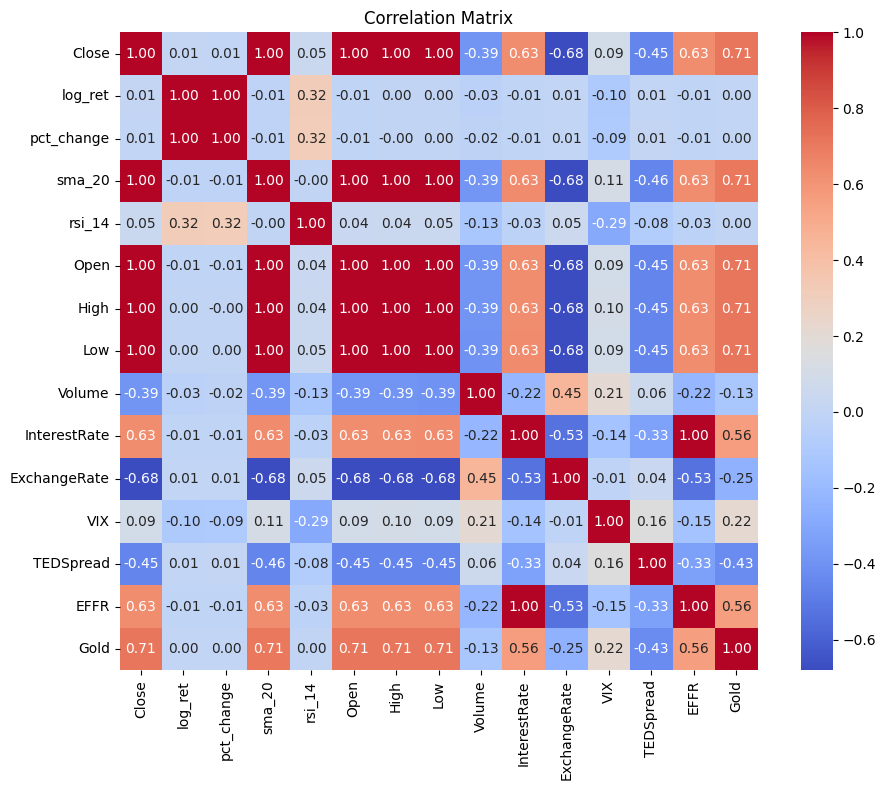

In [16]:
# Cell 6 – Correlation heat-map
base_feats  = ["Close", "log_ret", "pct_change", "sma_20", "rsi_14"]
macro_feats = [c for c in df.columns if c not in base_feats][:10]  # adjust as needed
corr = df[base_feats + macro_feats].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()

plt.savefig(FIG_DIR / "correlation_matrix.png", dpi=300, bbox_inches="tight")
plt.show()
